In [1]:
import polars as pl
import lightgbm as lgb
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime

from src.util.constants import PATH_RAW_TRAIN_SET, PATH_RAW_VALIDATE_SET
from src.util.common import grouped_spearman_correlation, save_as_pickle, customise_plot_style
from src.util.constants import DATA_PATH

In [2]:
NUMBER_OF_FOLDS = 5
ERAS_TO_PURGE = 4  # 4 weeks

In [3]:
df_train: pl.DataFrame = pl.read_parquet(PATH_RAW_TRAIN_SET)
df_validate: pl.DataFrame = pl.read_parquet(PATH_RAW_VALIDATE_SET)

In [4]:
df_all = pl.concat([df_train, df_validate])
del df_train, df_validate

df_all = df_all.filter(pl.col("target").is_not_null())
df_all = df_all.with_columns(pl.col("era").cast(pl.Int16))
df_all = df_all.drop([col for col in df_all.columns if "target_" in col] + ["data_type", 'id'])

In [5]:
feature_names = [x for x in df_all.columns if 'feature' in x]

number_of_observations = df_all.shape[0]
eras = df_all['era'].unique().to_list()
start_eras = [df_all['era'][round(number_of_observations * x / NUMBER_OF_FOLDS)] for x in range(NUMBER_OF_FOLDS)] + [df_all['era'].max() + 1]

In [6]:
fixed_parameters = {
    'objective': 'regression',
    'metric': 'None',
    "n_jobs": 12,  # current number of cores on my Mac - set this to hardware cores, not virtual threads
    "subsample_freq": 1,
    "verbose": -1
}

num_boost_round_space = [5, 20, 100]
num_leaves_space = [2**(x*2) - 1 for x in range(1, 6)]

In [7]:
results = []

for num_boost_round in num_boost_round_space:
    for num_leaves in num_leaves_space:
        parameters = {
            **fixed_parameters,
            'num_leaves': num_leaves,
            'num_boost_round': num_boost_round
        }

        result = []
        for fold in range(NUMBER_OF_FOLDS):
            train_eras = [x for x in eras if x < (start_eras[fold] - ERAS_TO_PURGE) or x > (start_eras[fold + 1] + ERAS_TO_PURGE)]
            validate_eras = [x for x in eras if start_eras[fold] <= x < start_eras[fold + 1]]

            df_train = df_all.filter(pl.col('era').is_in(train_eras))
            df_validate = df_all.filter(pl.col('era').is_in(validate_eras))

            lgb_train = lgb.Dataset(df_train[feature_names].to_numpy(), label=df_train['target'].to_numpy())
            lgb_validate = lgb.Dataset(df_validate[feature_names].to_numpy(), label=df_validate['target'].to_numpy())

            model = lgb.train(
                params=parameters,
                train_set=lgb_train,
                num_boost_round=parameters['num_boost_round']
            )

            df_validate = df_validate.with_columns(
                prediction=model.predict(df_validate[feature_names].to_numpy())
            )

            correlations = grouped_spearman_correlation(
                df_validate.select('prediction').to_series(),
                df_validate.select('target').to_series(),
                df_validate.select('era').to_series()
            ).to_list()

            result.extend(correlations)

            print(f'{datetime.now().strftime("%H:%M:%S")} . . . Model for num_leaves={num_leaves}, num_boost_round={num_boost_round}, and fold {fold} done.')

        results.append(result)
        (DATA_PATH / 'tmp').mkdir(parents=True, exist_ok=True)
        save_as_pickle(results, DATA_PATH / 'tmp/performance_over_time.pkl')

17:35:39 . . . Model for num_leaves=3, num_boost_round=5, and fold 0 done.
17:40:10 . . . Model for num_leaves=3, num_boost_round=5, and fold 1 done.
17:44:51 . . . Model for num_leaves=3, num_boost_round=5, and fold 2 done.
17:49:24 . . . Model for num_leaves=3, num_boost_round=5, and fold 3 done.
17:54:06 . . . Model for num_leaves=3, num_boost_round=5, and fold 4 done.
17:59:10 . . . Model for num_leaves=15, num_boost_round=5, and fold 0 done.
18:03:44 . . . Model for num_leaves=15, num_boost_round=5, and fold 1 done.
18:08:31 . . . Model for num_leaves=15, num_boost_round=5, and fold 2 done.
18:13:21 . . . Model for num_leaves=15, num_boost_round=5, and fold 3 done.
18:18:14 . . . Model for num_leaves=15, num_boost_round=5, and fold 4 done.
18:23:21 . . . Model for num_leaves=63, num_boost_round=5, and fold 0 done.
18:28:07 . . . Model for num_leaves=63, num_boost_round=5, and fold 1 done.
18:32:55 . . . Model for num_leaves=63, num_boost_round=5, and fold 2 done.
18:37:39 . . . Mo

In [7]:
# Drop all sub-lists from the list `results` that contain NaNs
results = [result for result in results if not any(math.isnan(value) for value in result)]
number_of_models = len(num_leaves_space) * len(num_boost_round_space)
print(f'{number_of_models - len(results)} out of {number_of_models} model results dropped due to NaNs.')

df_results = pl.DataFrame(
    results,
    [f'model_{i}' for i in range(len(results))],
    orient='col'
)

0 out of 15 model results dropped due to NaNs.


In [8]:
df_performance_corr = df_results.corr()
# HACKY, but does the trick: mask the diagonal
for i in range(len(df_performance_corr.columns)):
    df_performance_corr[i, i] = None


print(df_performance_corr.min().transpose().min())
print(df_performance_corr.median().transpose().median())
print(df_performance_corr.max().transpose().max())

shape: (1, 1)
┌──────────┐
│ column_0 │
│ ---      │
│ f64      │
╞══════════╡
│ 0.261247 │
└──────────┘
shape: (1, 1)
┌──────────┐
│ column_0 │
│ ---      │
│ f64      │
╞══════════╡
│ 0.613242 │
└──────────┘
shape: (1, 1)
┌──────────┐
│ column_0 │
│ ---      │
│ f64      │
╞══════════╡
│ 0.888623 │
└──────────┘


The performance of models is highly correlated.

In [9]:
df_ranking_corr = df_results.transpose().corr()
# HACKY, but does the trick: mask the diagonal
for i in range(len(df_ranking_corr.columns)):
    df_ranking_corr[i, i] = None

print(df_ranking_corr.min().transpose().min())
print(df_ranking_corr.median().transpose().median())
print(df_ranking_corr.max().transpose().max())

shape: (1, 1)
┌───────────┐
│ column_0  │
│ ---       │
│ f64       │
╞═══════════╡
│ -0.944853 │
└───────────┘
shape: (1, 1)
┌──────────┐
│ column_0 │
│ ---      │
│ f64      │
╞══════════╡
│ 0.219437 │
└──────────┘
shape: (1, 1)
┌──────────┐
│ column_0 │
│ ---      │
│ f64      │
╞══════════╡
│ 0.974293 │
└──────────┘


The ranking of model performance is also correlated, but with strongly negative values as well.

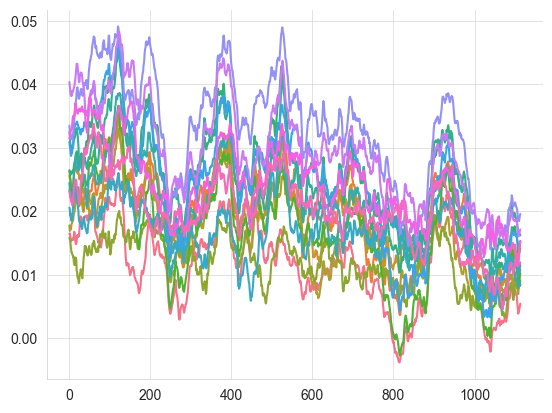

In [12]:
df_results_copy = df_results
for i in range(len(df_results_copy.columns)):
    df_results_copy = df_results_copy.with_columns(
        pl.col(f"model_{i}").rolling_mean(window_size=52).alias(f"mean_{i}")
    )

df_results_copy = df_results_copy[[x for x in df_results_copy.columns if 'mean' in x]].drop_nulls()

customise_plot_style()
sns.lineplot(data=df_results_copy, dashes=False, legend=False)
plt.show()

There is a long-term downward trend in performance.

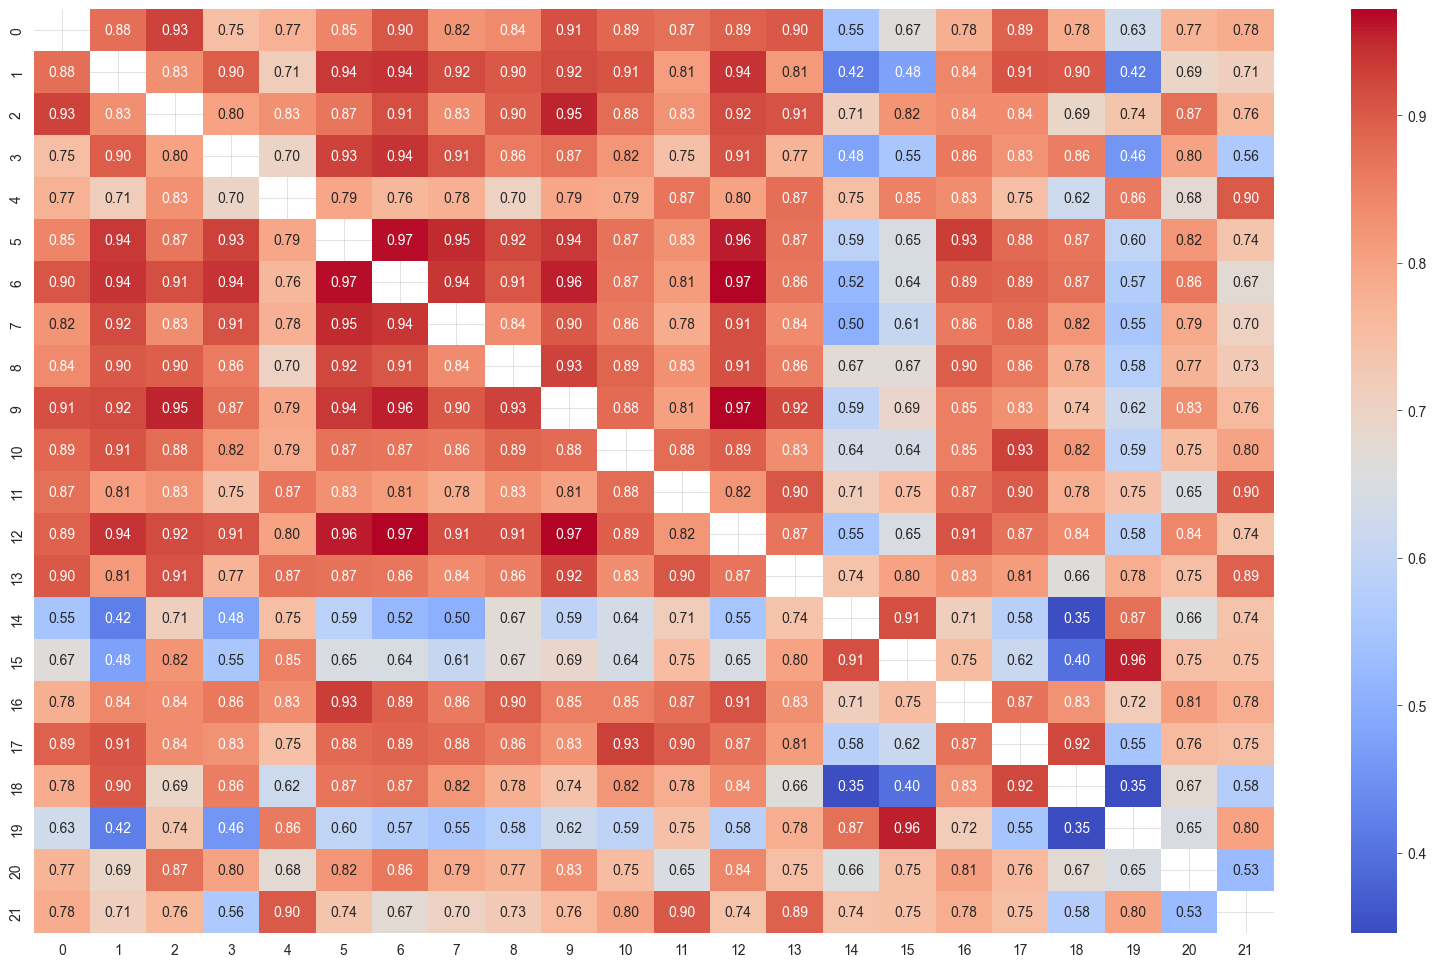

In [13]:
number_of_groups = int(len(eras) / 52.15)  # approximate years

start_eras = [df_all['era'][round(number_of_observations * x / number_of_groups)] for x in range(number_of_groups)] + [df_all['era'].max() + 1]

# assign each era to its group
group_lengths = [start_eras[i+1]-start_eras[i] for i in range(number_of_groups)]
group_labels = [i for i, length in enumerate(group_lengths) for _ in range(length)]
df_results = df_results.with_columns(
    index=pl.Series(group_labels)
)

# group by index and get column-wise mean
df_performance_by_group = (df_results.group_by('index', maintain_order=True)
                           .agg(pl.all().mean())[:, 1:len(df_results.columns)+1]
                           .transpose())

df_corr = df_performance_by_group.corr()

plt.figure(figsize=(20, 12))

# show the values in the heatmap, rounded to two decimals
sns.heatmap(df_corr.to_numpy(),
            mask=np.eye(df_corr.shape[0], dtype=bool),  # Create a mask for the diagonal to hide trivial perfect correlations
            annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

All correlations are above .35.

Conclusion: I will simply use the last 45% for three validation/test folds.